## SPATIAL TRANSCRIPTOMICS – IDENTIFICATION OF SVGs WITH SPATIALDE

### Environment setup

1. Install the necessary packages using `pip` if they are not already installed:

In [ ]:
# use conda env from readme

2. Import necessary libraries:

In [71]:
import numpy as np
import pandas as pd
import os
import NaiveDE
import SpatialDE
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import ipywidgets as w
w.IntSlider()
import csv

# cpu usage and time statistics
import psutil
import time
import platform

### Load the Datasets
Perform SpatialDE test on data in input files.

expression_csv : A CSV file with expression valies. Columns are genes,
and Rows are samples

coordinates_csv : A CSV file with sample coordinates. Each row is a sample,
the columns with coordinates must be named 'x' and 'y'. For other formats
(e.g. 1d or 3d queries), it is recommended to write a custom Python
script to do the analysis.

output_file : P-vaues and other relevant values for each gene
will be stored in this file, in CSV format.

In [2]:
# Edit these as needed
expression_csv = r"C:\MUNI\IV114_ST\data_after_qc\SN048_A121573_Rep2\count.not_normalized.csv"
coordinate_csv = r"C:\MUNI\IV114_ST\data_after_qc\SN048_A121573_Rep2\idx.not_normalized.csv"

# Base folder to save all output
base_dir = r"C:\MUNI\IV114_ST\data_after_qc\SN048_A121573_Rep1\results_spatialDE"
# Create folder if it doesn't exist
os.makedirs(base_dir, exist_ok=True)
results_csv = os.path.join(base_dir, "results.csv")

model_selection_csv = r"C:\MUNI\IV114_ST\data_after_qc\SN048_A121573_Rep2\results_spatialDE\model_selection.csv"
alfa_m = 0.05

### Get platform information

In [3]:
# ---- System info ----
cpu_model = platform.processor()
cpu_cores = psutil.cpu_count(logical=False)
cpu_threads = psutil.cpu_count(logical=True)

total_ram = psutil.virtual_memory().total / (1024**3)  # GB

print("CPU model:", cpu_model)
print("CPU cores:", cpu_cores)
print("CPU threads:", cpu_threads)
print("Total RAM: {:.2f} GB".format(total_ram))

# ---------------- SAVE TO CSV -----------------
csv_file = os.path.join(base_dir, "system_info.csv")

with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["CPU_model", "CPU_cores", "CPU_threads", "Total_RAM_GB"])
    writer.writerow([cpu_model, cpu_cores, cpu_threads, round(total_ram, 2)])

print(f"System info saved to {csv_file}")

CPU model: Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores: 4
CPU threads: 8
Total RAM: 7.79 GB
System info saved to data_after_qc\SN048_A121573_Rep2\results_spatialDE\system_info.csv


### SpatialDE analysis

In [ ]:
df = pd.read_csv(expression_csv, index_col=0)

df = df.T[df.sum(0) >= 10].T  # Filter practically unobserved genes

sample_info = pd.read_csv(coordinate_csv, index_col=0)

sample_info['total_counts'] = df.sum(1)
sample_info = sample_info.query('total_counts > 5')  # Remove empty features

df = df.loc[sample_info.index]   
X = sample_info[['x', 'y']]


# Convert data to log-scale, and account for depth
dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T


In [109]:
print("SpatialDE analysis")

process = psutil.Process(os.getpid())
process.cpu_percent(interval=None)   # reset counters

start_cpu = time.process_time()
start_wall = time.time()

# -------- code to measure -----------
# Perform Spatial DE test with default settings
results = SpatialDE.run(X, res)
# ------------------------------------

end_cpu = time.process_time()
end_wall = time.time()

cpu_time = end_cpu - start_cpu
wall_time = end_wall - start_wall
cpu_usage = process.cpu_percent(interval=None)
ram_usage = process.memory_info().rss / (1024**2)  # MB

print("CPU time: {:.6f} seconds".format(cpu_time))
print("Wall time: {:.6f} seconds".format(wall_time))
print("CPU usage (%):", cpu_usage)
print("RAM used by process: {:.2f} MB".format(ram_usage))

# ---------------- SAVE TO CSV -----------------
with open(os.path.join(base_dir,  "requirements.csv"), "a", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["somde analysis", cpu_time, wall_time, cpu_usage, ram_usage])


SpatialDE analysis


c:\Users\irato\miniconda3\envs\spatialde_py39\lib\site-packages\SpatialDE\base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
c:\Users\irato\miniconda3\envs\spatialde_py39\lib\site-packages\SpatialDE\base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19958 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
# Save results and annotation in files for interactive plotting and interpretation
results.to_csv(results_csv)

Optionally, we can generate a model-selection file for genes that have an adjusted p-value greater than alpha.


In [ ]:
de_results = results[(results.qval < alfa_m)].copy()
ms_results = SpatialDE.model_search(X, res, de_results)

ms_results.to_csv(model_selection_csv)

# Visualisation

If the analysis already done, you can download the results for visualisation.

In [72]:
# Edit these as needed
res_p = r"C:\MUNI\IV114_ST\data_after_qc\SN048_A121573_Rep1\res.csv"
results_p = r"C:\MUNI\IV114_ST\data_after_qc\SN048_A121573_Rep1\results.csv"
sample_info_p = r"C:\MUNI\IV114_ST\data_after_qc\SN048_A121573_Rep1\sample_info.csv"
model_selection_p = r"C:\MUNI\IV114_ST\data_after_qc\SN048_A121573_Rep1\model_selection.csv" # delete this if you did not do the model analysis
# Base folder to save all output
base_dir = r"C:\MUNI\IV114_ST\data_after_qc\SN048_A121573_Rep1\results_spatialDE"
# Create folder if it doesn't exist
os.makedirs(base_dir, exist_ok=True)

res = pd.read_csv(res_p, index_col=0)
results = pd.read_csv(results_p, index_col=0)
sample_info = pd.read_csv(sample_info_p, index_col=0)
model_selection = pd.read_csv(model_selection_p, index_col=0)  # delete this if you did not do the model analysis

In [73]:
# Edit these as needed
alfa_v = 0.05
fsv_thr = 0.5
llr_thr = 1000

Visualization of the data in a plot showing the fraction of spatial variance and the log-likelihood ratio for each gene. Both variables indicate how much better the spatial model fits compared to the null model. In both cases, larger values mean a higher probability that the gene is spatially variable.

Number of genes with q ≤ 0.05: 6999


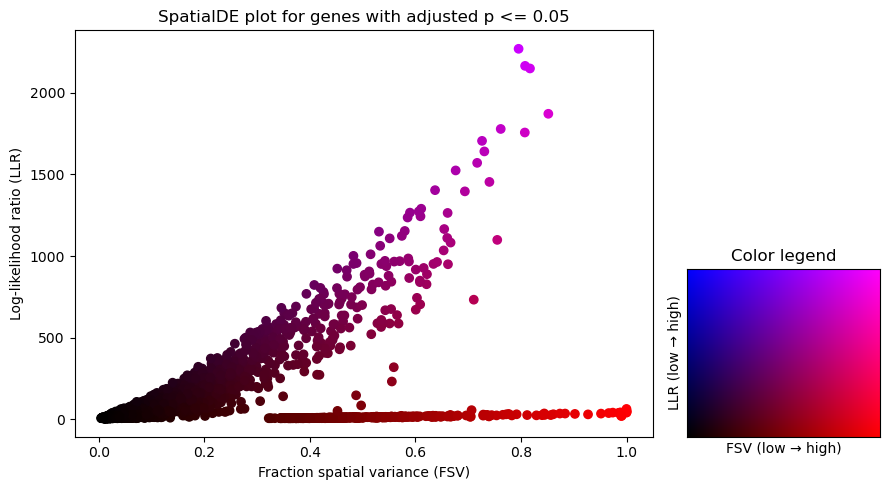

In [75]:
# Genes with adjusted p <= alfa_v
mask_q = results['qval'] <= alfa_v
x_q = results.loc[mask_q, 'FSV']
y_q = results.loc[mask_q, 'LLR']
print(f"Number of genes with q ≤ {alfa_v}: {len(x_q)}")

# Normalization LLR and FSV so it is in [0,1] for color channel
y_q_norm = (y_q - y_q.min()) / (y_q.max() - y_q.min())
x_q_norm = (x_q - x_q.min()) / (x_q.max() - x_q.min())

# ---- BUILD RGB COLOR ARRAY ----
# Red channel = FSV, Blue channel = normalized LLR
colors = np.zeros((len(x_q), 3))
colors[:, 0] = x_q_norm         # assumes FSV roughly in [0,1]; otherwise also normalize
colors[:, 2] = y_q_norm

fig = plt.figure(figsize=(9, 5))

# Main plot = 2 rows, legend = 1 row
gs = fig.add_gridspec(3, 2, width_ratios=[3, 1], height_ratios=[1,1,2])

# ---------------------- MAIN PLOT (LEFT 2 rows) ----------------------
ax = fig.add_subplot(gs[:, 0])

ax.scatter(x_q, y_q, c=colors)

ax.set_xlabel('Fraction spatial variance (FSV)')
ax.set_ylabel('Log-likelihood ratio (LLR)')
ax.set_title(f'SpatialDE plot for genes with adjusted p <= {alfa_v}')

# ---------------------- COLOR LEGEND (BOTTOM RIGHT) ----------------------
legend_ax = fig.add_subplot(gs[2, 1])

pix = 150
fsv_grad = np.linspace(0, 1, pix)
llr_grad = np.linspace(0, 1, pix)
F, S = np.meshgrid(fsv_grad, llr_grad)

legend_colors = np.zeros((pix, pix, 3))
legend_colors[..., 0] = F      # FSV in red channel
legend_colors[..., 2] = S      # LLR in blue channel

legend_ax.imshow(
    legend_colors,
    origin='lower',
    aspect='auto',
    extent=[0, 1, 0, 1]
)

legend_ax.set_xlabel('FSV (low → high)')
legend_ax.set_ylabel('LLR (low → high)')
legend_ax.set_title('Color legend')

legend_ax.set_xticks([])
legend_ax.set_yticks([])

plt.tight_layout()

# Save volcano plot
plot_file = os.path.join(base_dir, "first_plot.png")
plt.savefig(plot_file, dpi=300)
plt.show()


Then there are choosen the best genes.

Number of genes with adjusted p <= 0.05 and LLR ≥ 1000, FSV ≥ 0.5: 30


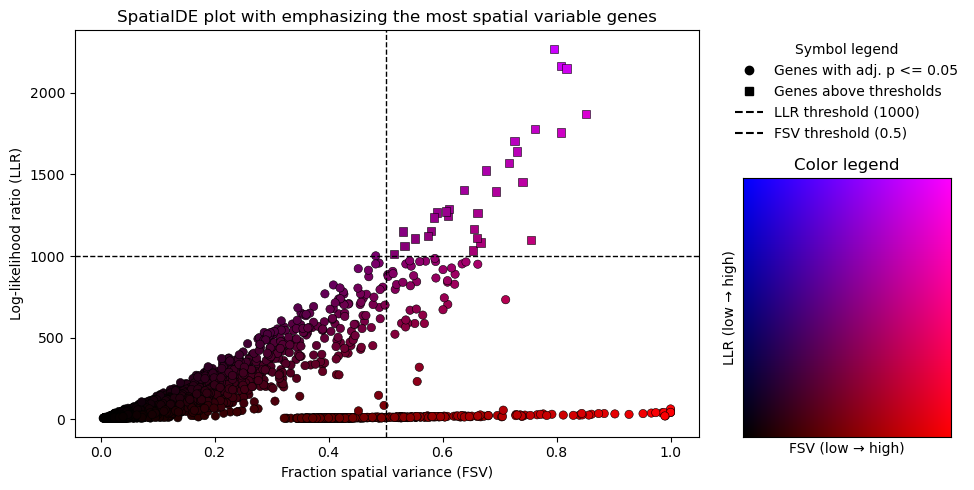

In [76]:
# Mask for upper-right quadrant: high FSV AND low q-value
mask_top_right = (x_q >= fsv_thr) & (y_q >= llr_thr) 
mask_top_right_np = mask_top_right.to_numpy()

# Mask for the other genes
mask_rest = ~mask_top_right 
mask_rest_np = ~mask_top_right_np

n_top_right = int(mask_top_right.sum())
print(f"Number of genes with adjusted p <= {alfa_v} and LLR ≥ {llr_thr}, FSV ≥ {fsv_thr}: {n_top_right}")

fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[0.6, 2])

# ===================== MAIN PLOT (LEFT) =====================
ax = fig.add_subplot(gs[:, 0])

# 1) All other genes as circles
ax.scatter(
    x_q[mask_rest],
    y_q[mask_rest],
    c=colors[mask_rest_np],
    marker='o',
    edgecolor='black',
    linewidth=0.4
)

# 2) Upper-right quadrant genes as squares 
ax.scatter(
    x_q[mask_top_right],
    y_q[mask_top_right],
    c=colors[mask_top_right_np],
    marker='s',
    edgecolor='black',
    linewidth=0.4
)

# Y-axis thresholds (horizontal lines) 
ax.axhline(llr_thr, c='black', lw=1, ls='--')  # LLR threshold 

# X-axis threshold (vertical line)
ax.axvline(fsv_thr, c='black', lw=1, ls='--')   # FSV threshold

ax.set_xlabel('Fraction spatial variance (FSV)')
ax.set_ylabel('Log-likelihood ratio (LLR)')
ax.set_title('SpatialDE plot with emphasizing the most spatial variable genes')

# ===================== 2D BIVARIATE COLOR LEGEND (BOTTOM RIGHT) =====================
legend_ax_bottom = fig.add_subplot(gs[1, 1])

pix = 150
fsv_grad = np.linspace(0, 1, pix)
llr_grad = np.linspace(0, 1, pix)
F, S = np.meshgrid(fsv_grad, llr_grad)

legend_colors = np.zeros((pix, pix, 3))
legend_colors[..., 0] = F      # FSV in red channel
legend_colors[..., 2] = S      # LLR in blue channel

legend_ax_bottom.imshow(
    legend_colors,
    origin='lower',
    aspect='auto',
    extent=[0, 1, 0, 1]
)

legend_ax_bottom.set_xlabel('FSV (low → high)')
legend_ax_bottom.set_ylabel('LLR (low → high)')
legend_ax_bottom.set_title('Color legend')

legend_ax_bottom.set_xticks([])
legend_ax_bottom.set_yticks([])

# ===================== SYMBOL LEGEND (TOP RIGHT, OWN AXES) =====================
legend_ax_top = fig.add_subplot(gs[0, 1])
legend_ax_top.axis('off')

scatter_proxy = mlines.Line2D(
    [], [], color='black', marker='o',
    linestyle='None', markersize=6,
    label=f'Genes with adj. p <= {alfa_v}'
)
square_proxy = mlines.Line2D(
    [], [], color='black', marker='s',
    linestyle='None', markersize=6,
    label='Genes above thresholds'
)
y_proxy = mlines.Line2D(
    [], [], color='black', linestyle='--',
    label=f'LLR threshold ({llr_thr})'
)
x_proxy = mlines.Line2D(
    [], [], color='black', linestyle='--',
    label=f'FSV threshold ({fsv_thr})'
)

legend_ax_top.legend(
    handles=[scatter_proxy, square_proxy, y_proxy, x_proxy],   
    loc='upper center',
    bbox_to_anchor=(0.5, 1.0),
    frameon=False,
    title='Symbol legend'
)

# ------------------------------------------------------------------
plt.tight_layout()

# Save the plot
plot_file = os.path.join(base_dir, "plot_best_genes.png")
plt.savefig(plot_file, dpi=300)
plt.show()

Graph of the tissue with the color correspond to expression level of top the genes, that was marked as the best priviously.

In [84]:
# Get gene names that pass the strict threshold
mask_strict = (results['FSV'] >= fsv_thr) & (results['LLR'] >= llr_thr) & (results['qval'] <= alfa_v)
strict_genes = results.loc[mask_strict, 'g']

# Dropdown will contain only genes passing strict threshold
strict_gene_list = list(strict_genes)

# Dictionary map for variables
fsv_map = results.set_index('g')['FSV'].to_dict()
llr_map = results.set_index('g')['LLR'].to_dict()
# Delete next two lines if you did not do model selection analysis
model_map = model_selection.set_index('g')['model'].to_dict()
l_map = model_selection.set_index('g')['l'].to_dict()

# Function to plot a selected gene
def plot_gene(gene):

    fsv = fsv_map[gene]
    llr = llr_map[gene]
    model  = model_map[gene]
    l = l_map[gene]

    # TITLE – first line: gene, LLR, FSV
    title_main = f"Gene: {gene}, LLR: {llr:.3f}, FSV: {fsv:.3f},"

    # SECOND LINE – model + parameter (l or p)  (delete this part if you did not do model selection analysis)
    if model == "SE":
        title_sub = f"model = squared exponential, l = {l:.3f}"
    elif model == "PER":
        title_sub = f"model = periodic, p = {l:.3f}"
    else:
        title_sub = "model = linear"

    full_title = title_main + "\n" + title_sub

    # square-ish figure, no extra empty space
    fig, ax = plt.subplots(figsize=(6, 6))

    sc = ax.scatter(
        sample_info['x'],
        sample_info['y'],
        c=res[gene],
        cmap='viridis',
        s=20,             
        edgecolors='none'
    )

    ax.set_title(full_title, fontsize=12)  # change full_title on title_main if you did not do model selection analysis
    ax.set_aspect('equal')

    # remove ticks (cleaner map)
    ax.set_xticks([])
    ax.set_yticks([])

    # --- COLORBAR ---
    # fraction = how thick; pad = distance from plot
    cbar = fig.colorbar(sc, ax=ax, fraction=0.035, pad=0.01)
    cbar.set_label('Expression', fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    # Save
    file_path = os.path.join(base_dir, f"{gene}.png")
    fig.savefig(file_path, dpi=300)

    plt.show()
    plt.close(fig)


# ---- Interactive dropdown ----
w.interact(
    plot_gene,
    gene=w.Dropdown(options=strict_gene_list, description="SVG:")
)

interactive(children=(Dropdown(description='SVG:', options=('PLA2G2A', 'PIGR', 'REG1A', 'RPL37A', 'AGR2', 'SPI…

<function __main__.plot_gene(gene)>

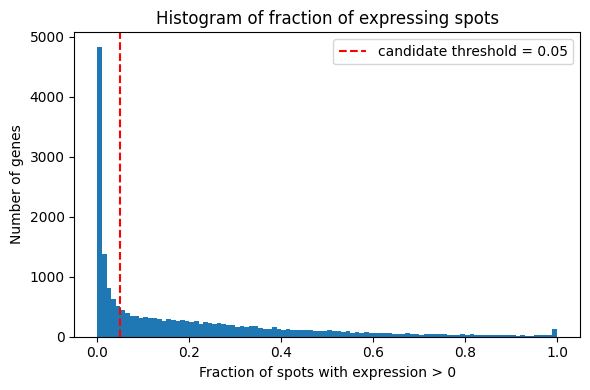

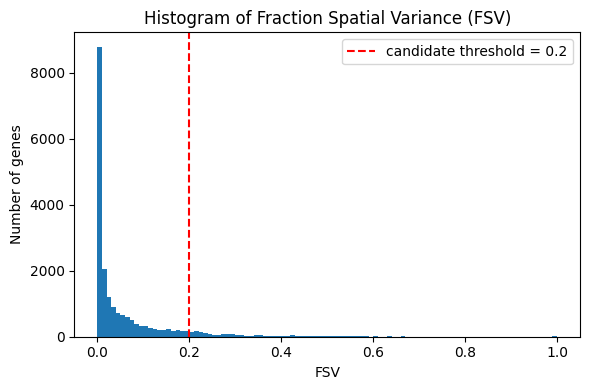

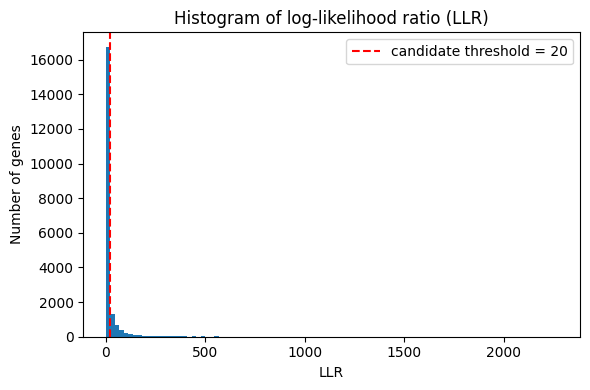

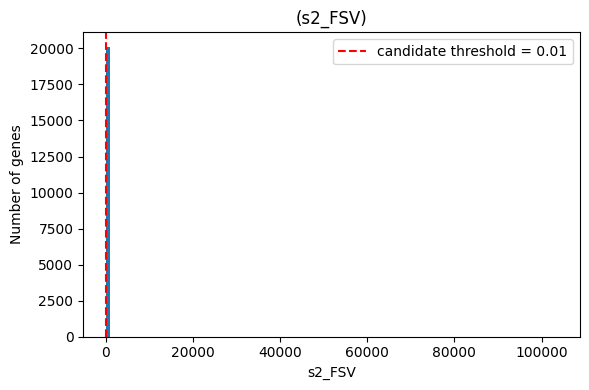

In [ ]:

# Create maps for gene → l and gene → qval (using strict genes)
#l_map = results.set_index('g')['l'].to_dict()    
qval_map = results.set_index('g')['qval'].to_dict()
# ---------------------------------------------------
# ZÁKLAD: načtené výsledky SpatialDE
# results = pd.read_csv(results_p, index_col=0)
# ---------------------------------------------------

# === 0) Kam ukládat obrázky (stejná složka jako results.csv) ===
base_dir = os.path.dirname(results_p)
os.makedirs(base_dir, exist_ok=True)

# === 1) fraction_expressing: načti stejný count matrix jako pro SpatialDE ===
# -> uprav tuhle cestu na svůj soubor s raw counts pro SN048_A121573_Rep1

counts = pd.read_csv(expression_csv, index_col=0)   # rows = spots, cols = genes

# necháme si jen geny, které se objevují v results (stejné pořadí)
genes = results['g'].values
counts = counts[genes]

# podíl spotů, kde je count > 0
fraction_expressing = (counts > 0).sum(axis=0) / counts.shape[0]

# přidáme si ho do results pro další práci (hodí se později)
results['fraction_expressing'] = fraction_expressing.values

# === 2) Histogram fraction_expressing ===
plt.figure(figsize=(6, 4))
plt.hist(results['fraction_expressing'].dropna(), bins=100)
plt.axvline(0.05, color='red', linestyle='--', label='candidate threshold = 0.05')
plt.xlabel('Fraction of spots with expression > 0')
plt.ylabel('Number of genes')
plt.title('Histogram of fraction of expressing spots')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "hist_fraction_expressing.png"), dpi=300)
plt.show()

# === 3) Histogram FSV ===
plt.figure(figsize=(6, 4))
plt.hist(results['FSV'].dropna(), bins=100)
plt.axvline(0.2, color='red', linestyle='--', label='candidate threshold = 0.2')
plt.xlabel('FSV')
plt.ylabel('Number of genes')
plt.title('Histogram of Fraction Spatial Variance (FSV)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "hist_FSV.png"), dpi=300)
plt.show()

# === 4) Histogram LLR ===
plt.figure(figsize=(6, 4))
plt.hist(results['LLR'].dropna(), bins=100)
plt.axvline(20, color='red', linestyle='--', label='candidate threshold = 20')
plt.xlabel('LLR')
plt.ylabel('Number of genes')
plt.title('Histogram of log-likelihood ratio (LLR)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "hist_LLR.png"), dpi=300)
plt.show()

# === 4) Histogram s2_FSV ===
plt.figure(figsize=(6, 4))
plt.hist(results['s2_FSV'].dropna(), bins=100)
plt.axvline(0.01, color='red', linestyle='--', label='candidate threshold = 0.01')
plt.xlabel('s2_FSV')
plt.ylabel('Number of genes')
plt.title('(s2_FSV)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "hist_s2_FSV.png"), dpi=300)
plt.show()

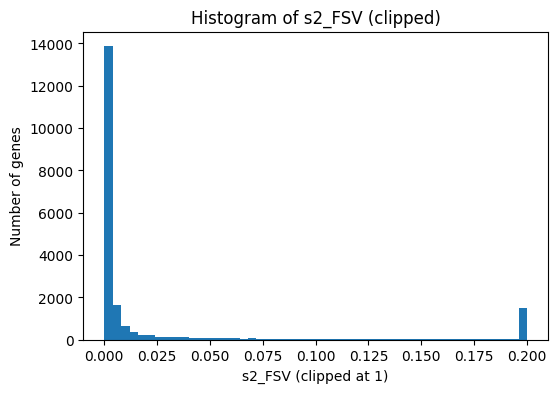

In [30]:
vals = results['s2_FSV'].clip(upper=0.2)  # hodnoty >1 nastavíme na 1

plt.figure(figsize=(6,4))
plt.hist(vals, bins=50)
plt.xlabel("s2_FSV (clipped at 1)")
plt.ylabel("Number of genes")
plt.title("Histogram of s2_FSV (clipped)")
plt.show()

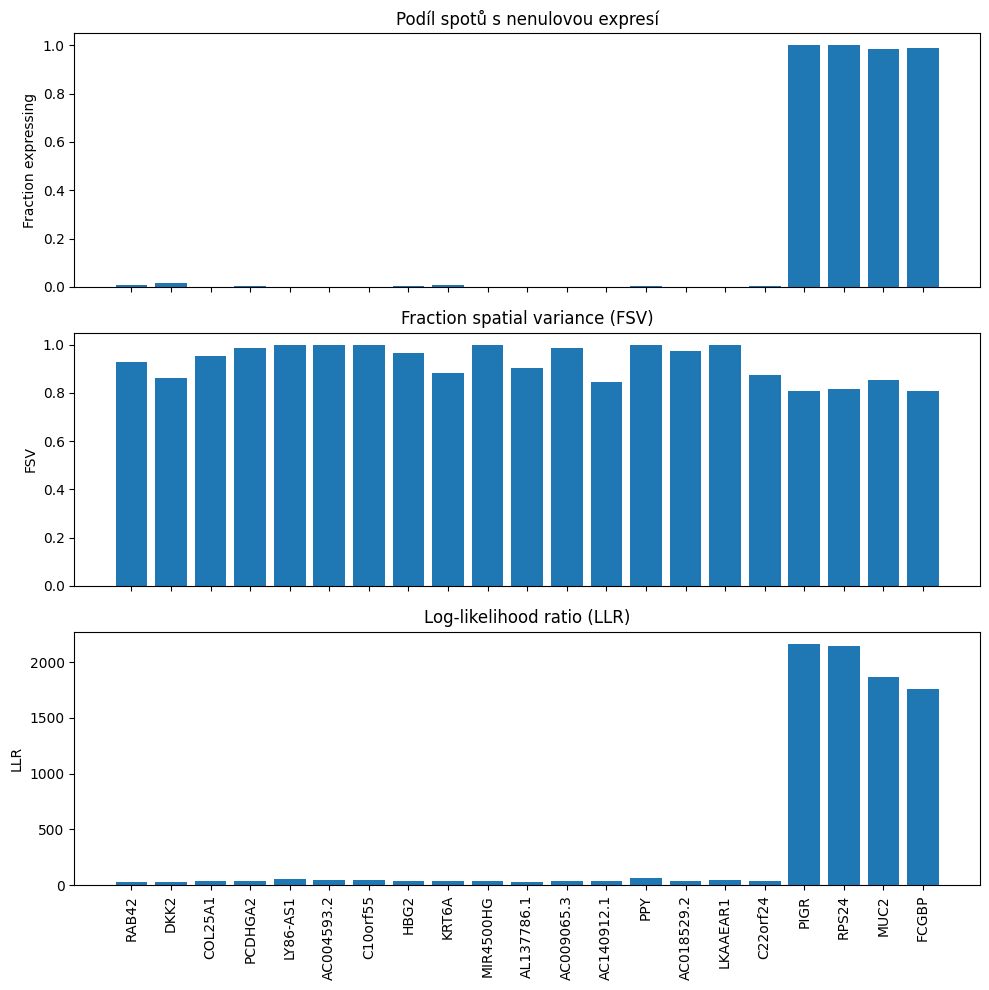

In [44]:


# ---------- 1) Definice genů ----------
genes_of_interest = [
    "RAB42",
    "DKK2",
    "COL25A1",
    "PCDHGA2",
    "LY86-AS1",
    "AC004593.2",
    "C10orf55",
    "HBG2",
    "KRT6A",
    "MIR4500HG",
    "AL137786.1",
    "AC009065.3",
    "AC140912.1",
    "PPY",
    "AC018529.2",
    "LKAAEAR1",
    "C22orf24", 
    "PIGR",
    "RPS24",
    "MUC2",
    "FCGBP"
]

# ---------- 2) Podmnožina results jen pro tyto geny ----------
sub = results[results["g"].isin(genes_of_interest)].copy()

# zachovat pořadí podle seznamu genes_of_interest
sub["gene_order"] = sub["g"].map({g: i for i, g in enumerate(genes_of_interest)})
sub = sub.sort_values("gene_order")

x_pos = np.arange(len(sub))
gene_labels = sub["g"].tolist()

# ---------- 2) Dopotítat fraction_expressing, pokud ještě není v results ----------
if "fraction_expressing" not in results.columns:
    # Cesta k raw counts pro TUTO sample (stejnou, jako jsi používala pro SpatialDE)
    expr_counts_path = r"C:\MUNI\IV114_ST\data_after_qc\SN048_A121573_Rep1\count.not_normalized.csv"
    counts = pd.read_csv(expr_counts_path, index_col=0)  # rows = spots, cols = genes
    
    # necháme si jen geny, které máme v results a jsou i v count matici
    common_genes = [g for g in results["g"] if g in counts.columns]
    counts = counts[common_genes]
    
    # podíl spotů s expresí > 0
    fraction_expressing = (counts > 0).sum(axis=0) / counts.shape[0]
    
    # zarovnat podle results['g']
    frac_series = fraction_expressing.reindex(results["g"])
    results["fraction_expressing"] = frac_series.values

# ---------- 3) Vybrat jen řádky pro dané geny ----------
sub = results[results["g"].isin(genes_of_interest)].copy()

# pro jistotu setřídíme podle pořadí v seznamu genes_of_interest
sub["gene_order"] = sub["g"].map({g: i for i, g in enumerate(genes_of_interest)})
sub = sub.sort_values("gene_order")

# x osa = indexy 0..n-1
x_pos = np.arange(len(sub))

# ---------- 4) Vykreslit 3 subplots: fraction_expressing, FSV, LLR ----------
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# a) fraction_expressing
axes[0].bar(x_pos, sub["fraction_expressing"])
axes[0].set_ylabel("Fraction expressing")
axes[0].set_title("Podíl spotů s nenulovou expresí")

# b) FSV
axes[1].bar(x_pos, sub["FSV"])
axes[1].set_ylabel("FSV")
axes[1].set_title("Fraction spatial variance (FSV)")

# c) LLR
axes[2].bar(x_pos, sub["LLR"])
axes[2].set_ylabel("LLR")
axes[2].set_title("Log-likelihood ratio (LLR)")
# společná X osa = názvy genů
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(sub["g"], rotation=90)

plt.tight_layout()

# uložit obrázek (pokud chceš)
base_dir = os.path.dirname(results_p)
out_path = os.path.join(base_dir, "genes_of_interest_fraction_FSV_LLR.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")

plt.show()

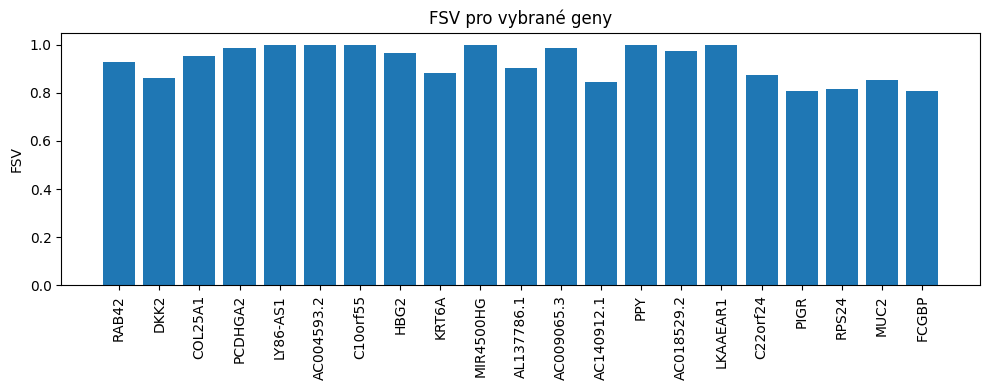

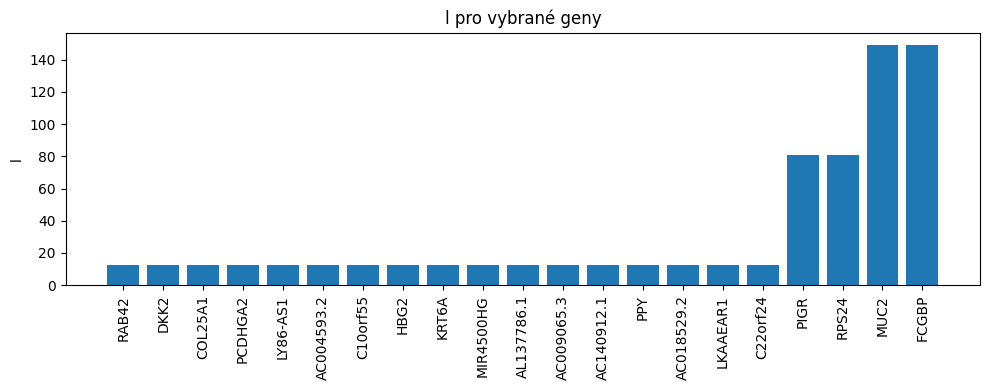

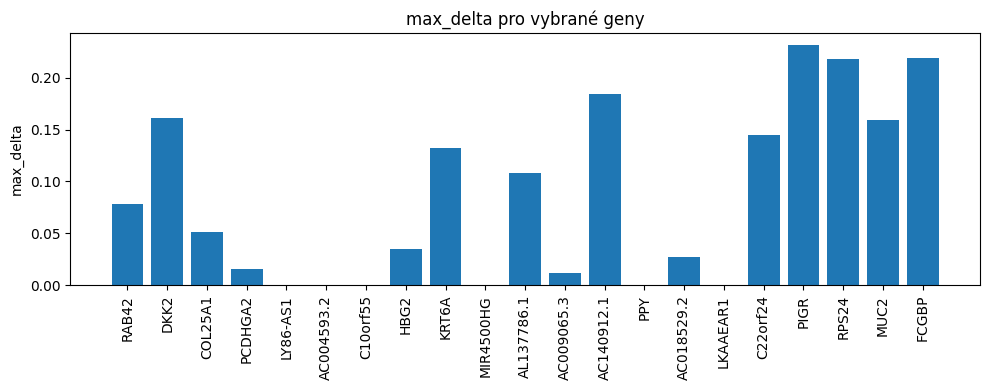

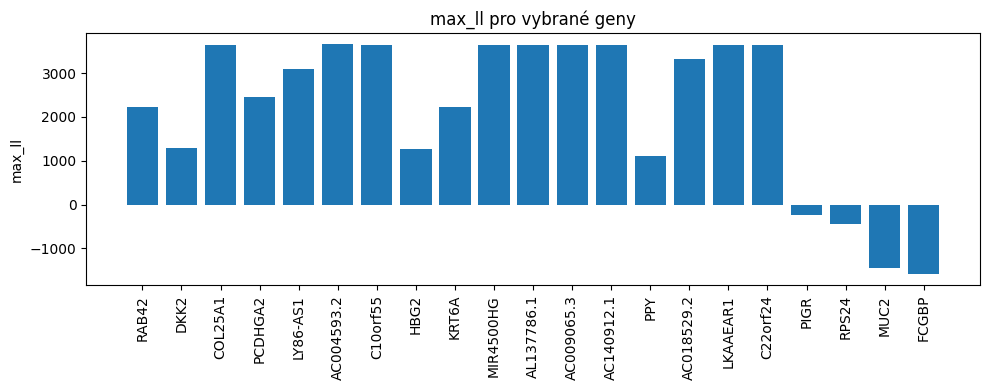

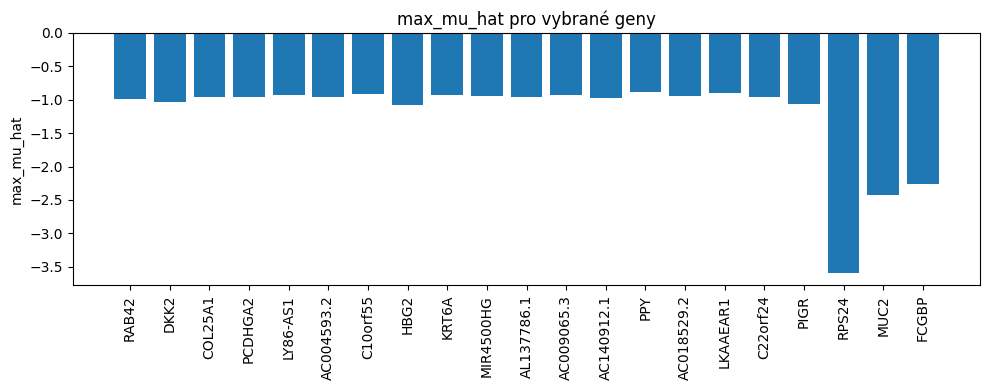

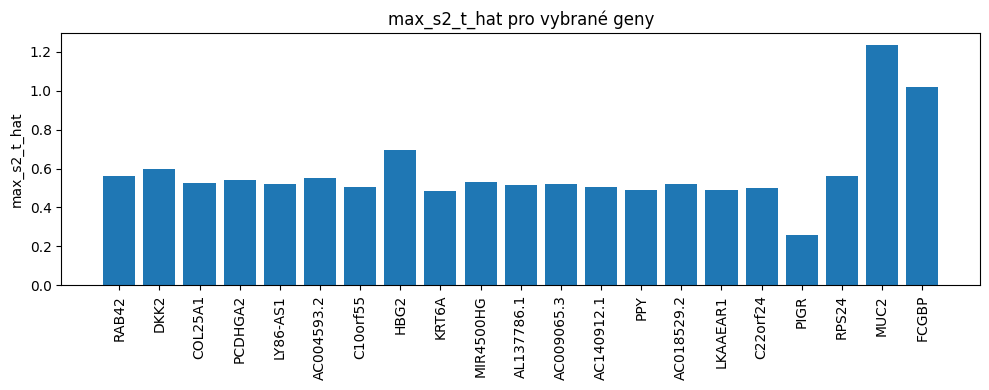

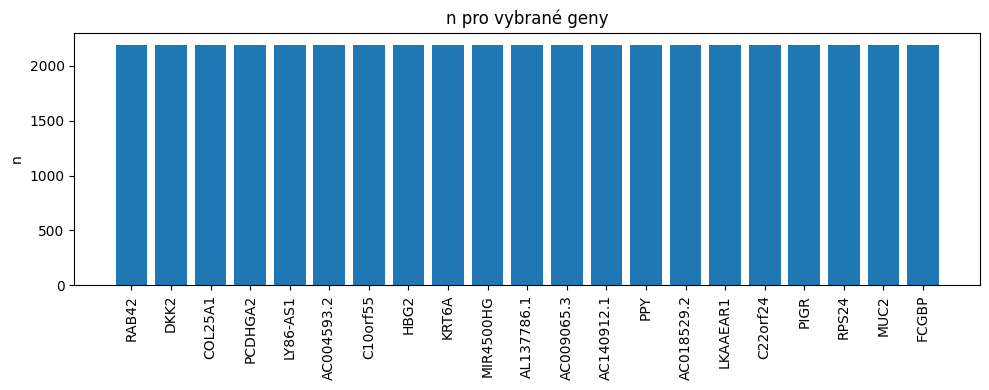

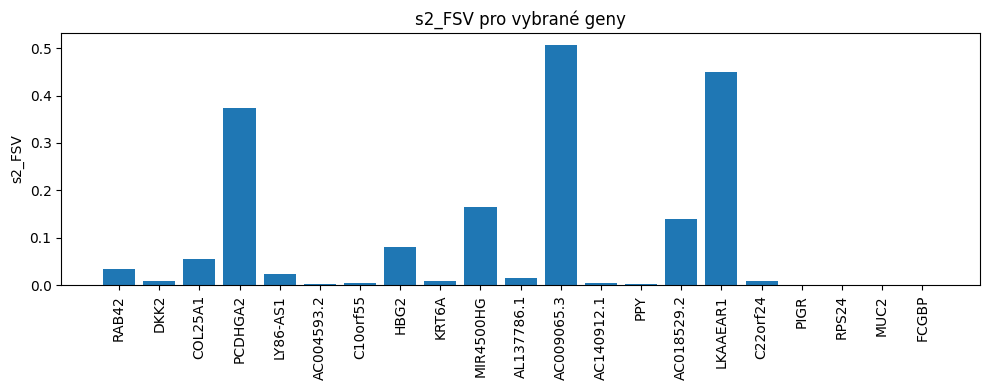

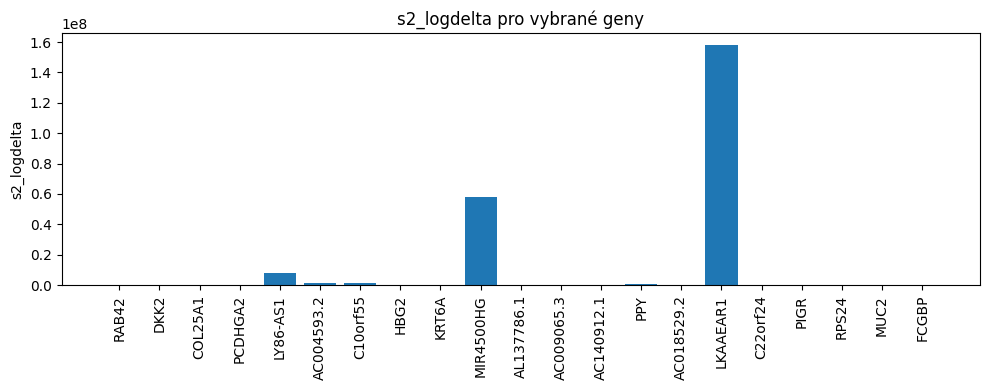

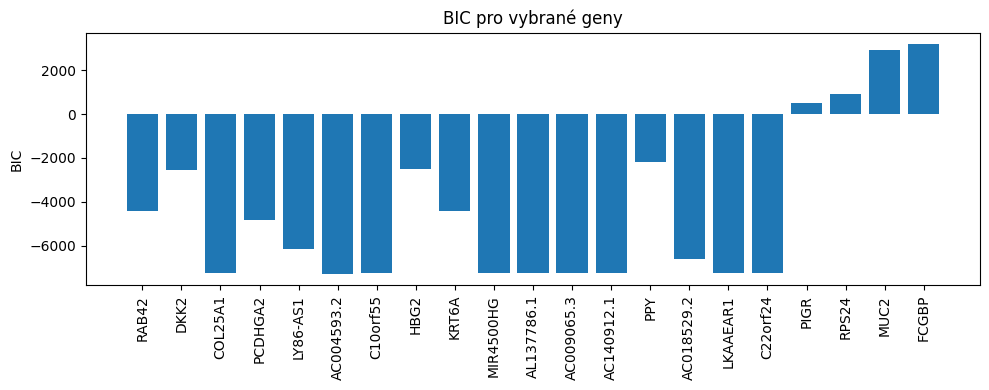

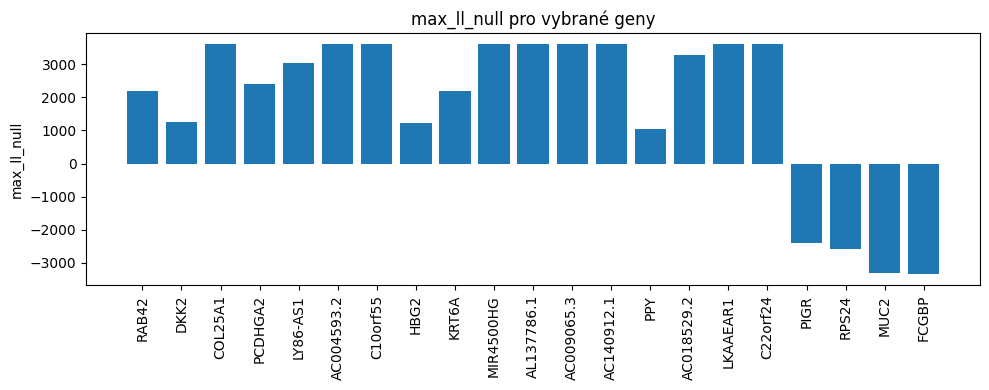

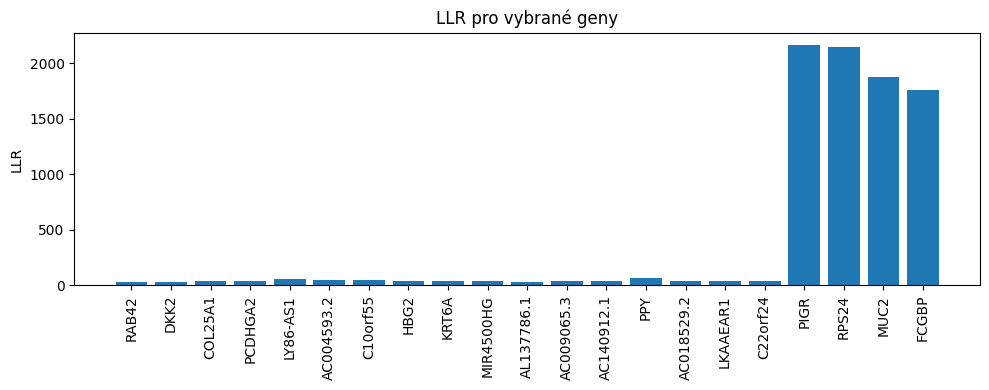

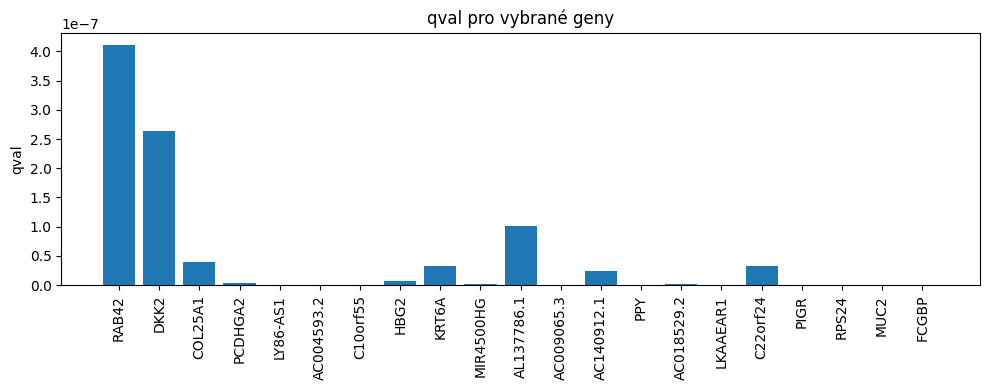

In [23]:
# ---------- 3) Seznam proměnných, které chceme vykreslit ----------
vars_to_plot = [
    "FSV",
    "l",
    "max_delta",
    "max_ll",
    "max_mu_hat",
    "max_s2_t_hat",
    "n",
    "s2_FSV",
    "s2_logdelta",
    "BIC",
    "max_ll_null",
    "LLR",
    "qval"
]

# složka pro uložení obrázků
base_dir = os.path.dirname(results_p)
os.makedirs(base_dir, exist_ok=True)

# ---------- 4) Smyčka přes proměnné a vykreslení barplotu ----------
for var in vars_to_plot:
    if var not in sub.columns:
        print(f"Var '{var}' není ve sloupcích results – přeskočeno.")
        continue

    values = sub[var].values

    plt.figure(figsize=(10, 4))
    plt.bar(x_pos, values)
    plt.xticks(x_pos, gene_labels, rotation=90)
    plt.ylabel(var)
    plt.title(f"{var} pro vybrané geny")

    plt.tight_layout()

    # uložit obrázek
    out_path = os.path.join(base_dir, f"genes_of_interest_{var}.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()